In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from pdpbox import pdp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import ElasticNet
from PyALE import ale
import shap
shap.initjs()
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline


#### Data

In [ ]:
# Read the data from the Excel file
df = pd.read_excel('../data/base_final.xlsx')

# Get the column names
column_names = df.columns.tolist()

In [ ]:
# Plot data

# Create a copy of the DataFrame
df_copy = df.copy()

# Add a new column that represents the index of each row
df_copy['Index'] = df_copy.index

# Convert the DataFrame to a long format
df_copy = df_copy.melt(id_vars='Index', var_name='Variable', value_name='Value')

# Create a FacetGrid object
g = sns.FacetGrid(df_copy, col="Variable", col_wrap=5, height=3,sharey=False)

# Map a line plot to each facet
g = g.map(plt.plot, "Index", "Value")

# Add a title to each facet
g = g.set_titles("{col_name}")

# Show the plot
plt.show()



In [ ]:
# Define the target variable
target = df['ibc']

# Create lagged predictors
df_lagged = df.shift(1)

# Drop the first row which will be NaN
df_lagged = df_lagged.dropna()

# Standardize the predictors
scaler = StandardScaler()
df_lagged_scaled = pd.DataFrame(scaler.fit_transform(df_lagged), columns=df_lagged.columns)

# Drop the first row from the target
target = target[1:]


In [ ]:
# Compute the correlation matrix
corr_matrix = df_lagged_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features 
df_lagged_scaled = df_lagged_scaled.drop(df_lagged_scaled[to_drop], axis=1)

column_names_final = df_lagged_scaled.columns.tolist()

In [ ]:
# Calculate the split index
split_index = int(len(df_lagged_scaled) * 0.7)

# Split the data into training and testing sets
X_train = df_lagged_scaled[:split_index]
X_test = df_lagged_scaled[split_index:]
y_train = target[:split_index]
y_test = target[split_index:]

#### Model-specific interpretability

#### Elastic net model

In [ ]:
# Initialize the ElasticNet model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Fit the model
elastic_net.fit(X_train, y_train)

# Get the coefficients
coefficients = elastic_net.coef_

# Create a DataFrame for visualization
coefficients_df = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient'])

# Sort coefficients
sorted_coefficients = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Filter out features with zero coefficients
non_zero_coefficients = sorted_coefficients[sorted_coefficients['Coefficient'] != 0]

# Plot
plt.figure(figsize=(30, 25))
non_zero_coefficients.plot(kind='barh', legend=False)
plt.title('Elastic Net Coefficients')
plt.gca().invert_yaxis()  # Invert the y-axis so the feature with the highest coefficient is on top
plt.show()


#### A gradient boosting model

In [ ]:
# Define the XGBoost model with predefined hyperparameters
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         max_depth=5, 
                         learning_rate=0.1, 
                         n_estimators=200, 
                         gamma=0.2, 
                         subsample=0.7, 
                         colsample_bytree=0.7, 
                         min_child_weight=2)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Now you can use the trained model to make predictions on the test data
y_test_pred = model.predict(X_test)


In [ ]:
# Calculate the performance metrics for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Print the performance metrics for the training set
print(f'Training set RMSE: {rmse_train}')
print(f'Training set R-squared: {r2_train}')

# Calculate the performance metrics for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Print the performance metrics for the test set
print(f'Test set RMSE: {rmse_test}')
print(f'Test set R-squared: {r2_test}')

In [ ]:

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the target and predictions for the training set
plt.plot(y_train.index, y_train, label='Training set target', color='blue')
plt.plot(y_train.index, y_train_pred, label='Training set predictions', color='darkblue')

# Plot the target and predictions for the test set
plt.plot(y_test.index, y_test, label='Test set target', color='red')
plt.plot(y_test.index, y_test_pred, label='Test set predictions', color='darkred')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Get feature importance
importance = model.feature_importances_

# Convert feature importance into a DataFrame
importance_df = pd.DataFrame({
    'Feature': df_lagged_scaled.columns,
    'Importance': importance
})

# Sort DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the importance of the top 20 features
importance_df[:20].plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()  # Invert the y-axis so the feature with the highest importance is on top
plt.xlabel('Importance (Gain)')  # Add x-axis label
plt.show()



#### Model-agnostic interpretability

##### Permutation importance

In [ ]:

# Compute permutation feature importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=50, random_state=42, n_jobs=-1)

# Get importance scores
importance_scores = perm_importance.importances_mean

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': column_names_final,
    'Importance': importance_scores
})

# Sort DataFrame by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Select top 20 features
top_20_features = importance_df[:20]

# Plot feature importance
top_20_features.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()  # Invert the y-axis so the feature with the highest importance is on top
plt.xlabel('Permutation Importance')
plt.show()



##### Partial dependence plots

In [ ]:

# Get top 20 features
top_features = importance_df['Feature'][:20]

# Loop through top features and plot PDP
for feature in top_features:
    pdp_goals = pdp.PDPIsolate(model=model, 
                               df=df_lagged_scaled.copy(), 
                               model_features=column_names_final, 
                               feature_name=feature,
                               feature=feature,
                               n_classes=0,
                               num_grid_points=50,)
    fig, axes = pdp_goals.plot(engine='matplotlib', plot_lines=True)
    axes['line_axes'][0].set_ylabel('Marginal effect on IBC')  
    plt.title(f'PDP for feature {feature}')
    plt.show()



##### Interaction plots

In [ ]:
features = ['ibc','selic252']

interactions = pdp.PDPInteract(model=model, 
                               df=df_lagged_scaled.copy(), 
                               model_features=column_names_final, 
                               feature_names=features,
                               features=features,
                               n_classes=0,
                               num_grid_points=50,
                               pred_func=None,
                               memory_limit=0.5,
                               chunk_size=-1,
                               n_jobs=-1,
                               predict_kwds={},
                               data_transformer=None,
                               grid_types='percentile',
                               percentile_ranges=None,
                               grid_ranges=None,
                               cust_grid_points=None,)

fig, axes = interactions.plot(
    plot_type="contour",
    to_bins=False,
    show_percentile=True,
    engine='plotly',
    template='plotly_white',
)
iplot(fig)

In [ ]:
# Ilustrating the problem with PDPs: unrealistic predictions

def calculate_partial_dependence(model, X, feature_index):
    # Get unique values of feature
    unique_feature_values = np.sort(X.iloc[:, feature_index].unique())
    
    # Initialize array for storing partial dependence values
    pdp_values = np.zeros(unique_feature_values.shape)
    
    # Initialize a DataFrame for storing individual predictions
    individual_predictions = pd.DataFrame(index=unique_feature_values)
    
    # Make a copy of the data
    X_temp = X.copy()
    
    # Get the column name from the feature index
    feature_name = X.columns[feature_index]
    
    # Calculate partial dependence and individual predictions
    for i, feature_value in enumerate(unique_feature_values):
        # Set the feature value
        X_temp[feature_name] = feature_value
        
        # Get predictions
        predictions = model.predict(X_temp)
        
        # Store average prediction
        pdp_values[i] = np.mean(predictions)
        
        # Store individual predictions
        individual_predictions[feature_value] = predictions
        
    return unique_feature_values, pdp_values, individual_predictions

# Assume `model` is your trained model, `X` is your dataset, and `feature_index` is the index of the feature
feature_values, pdp_values, individual_predictions = calculate_partial_dependence(model, X_train, feature_index=1)

# Plot individual predictions
for column in individual_predictions.columns:
    plt.plot(individual_predictions.index, individual_predictions[column], color='red', alpha=0.1)

plt.show()


##### Acumulated local effects

In [ ]:
# Get top 20 features
top_features = importance_df['Feature'][:20]

# Loop through top features and plot ALE
for feature in top_features:
    ale_eff = ale(
    X=X_train,
    model=model,
    feature=[feature],
    grid_size=50,
    include_CI=False
)

##### Surrogate model

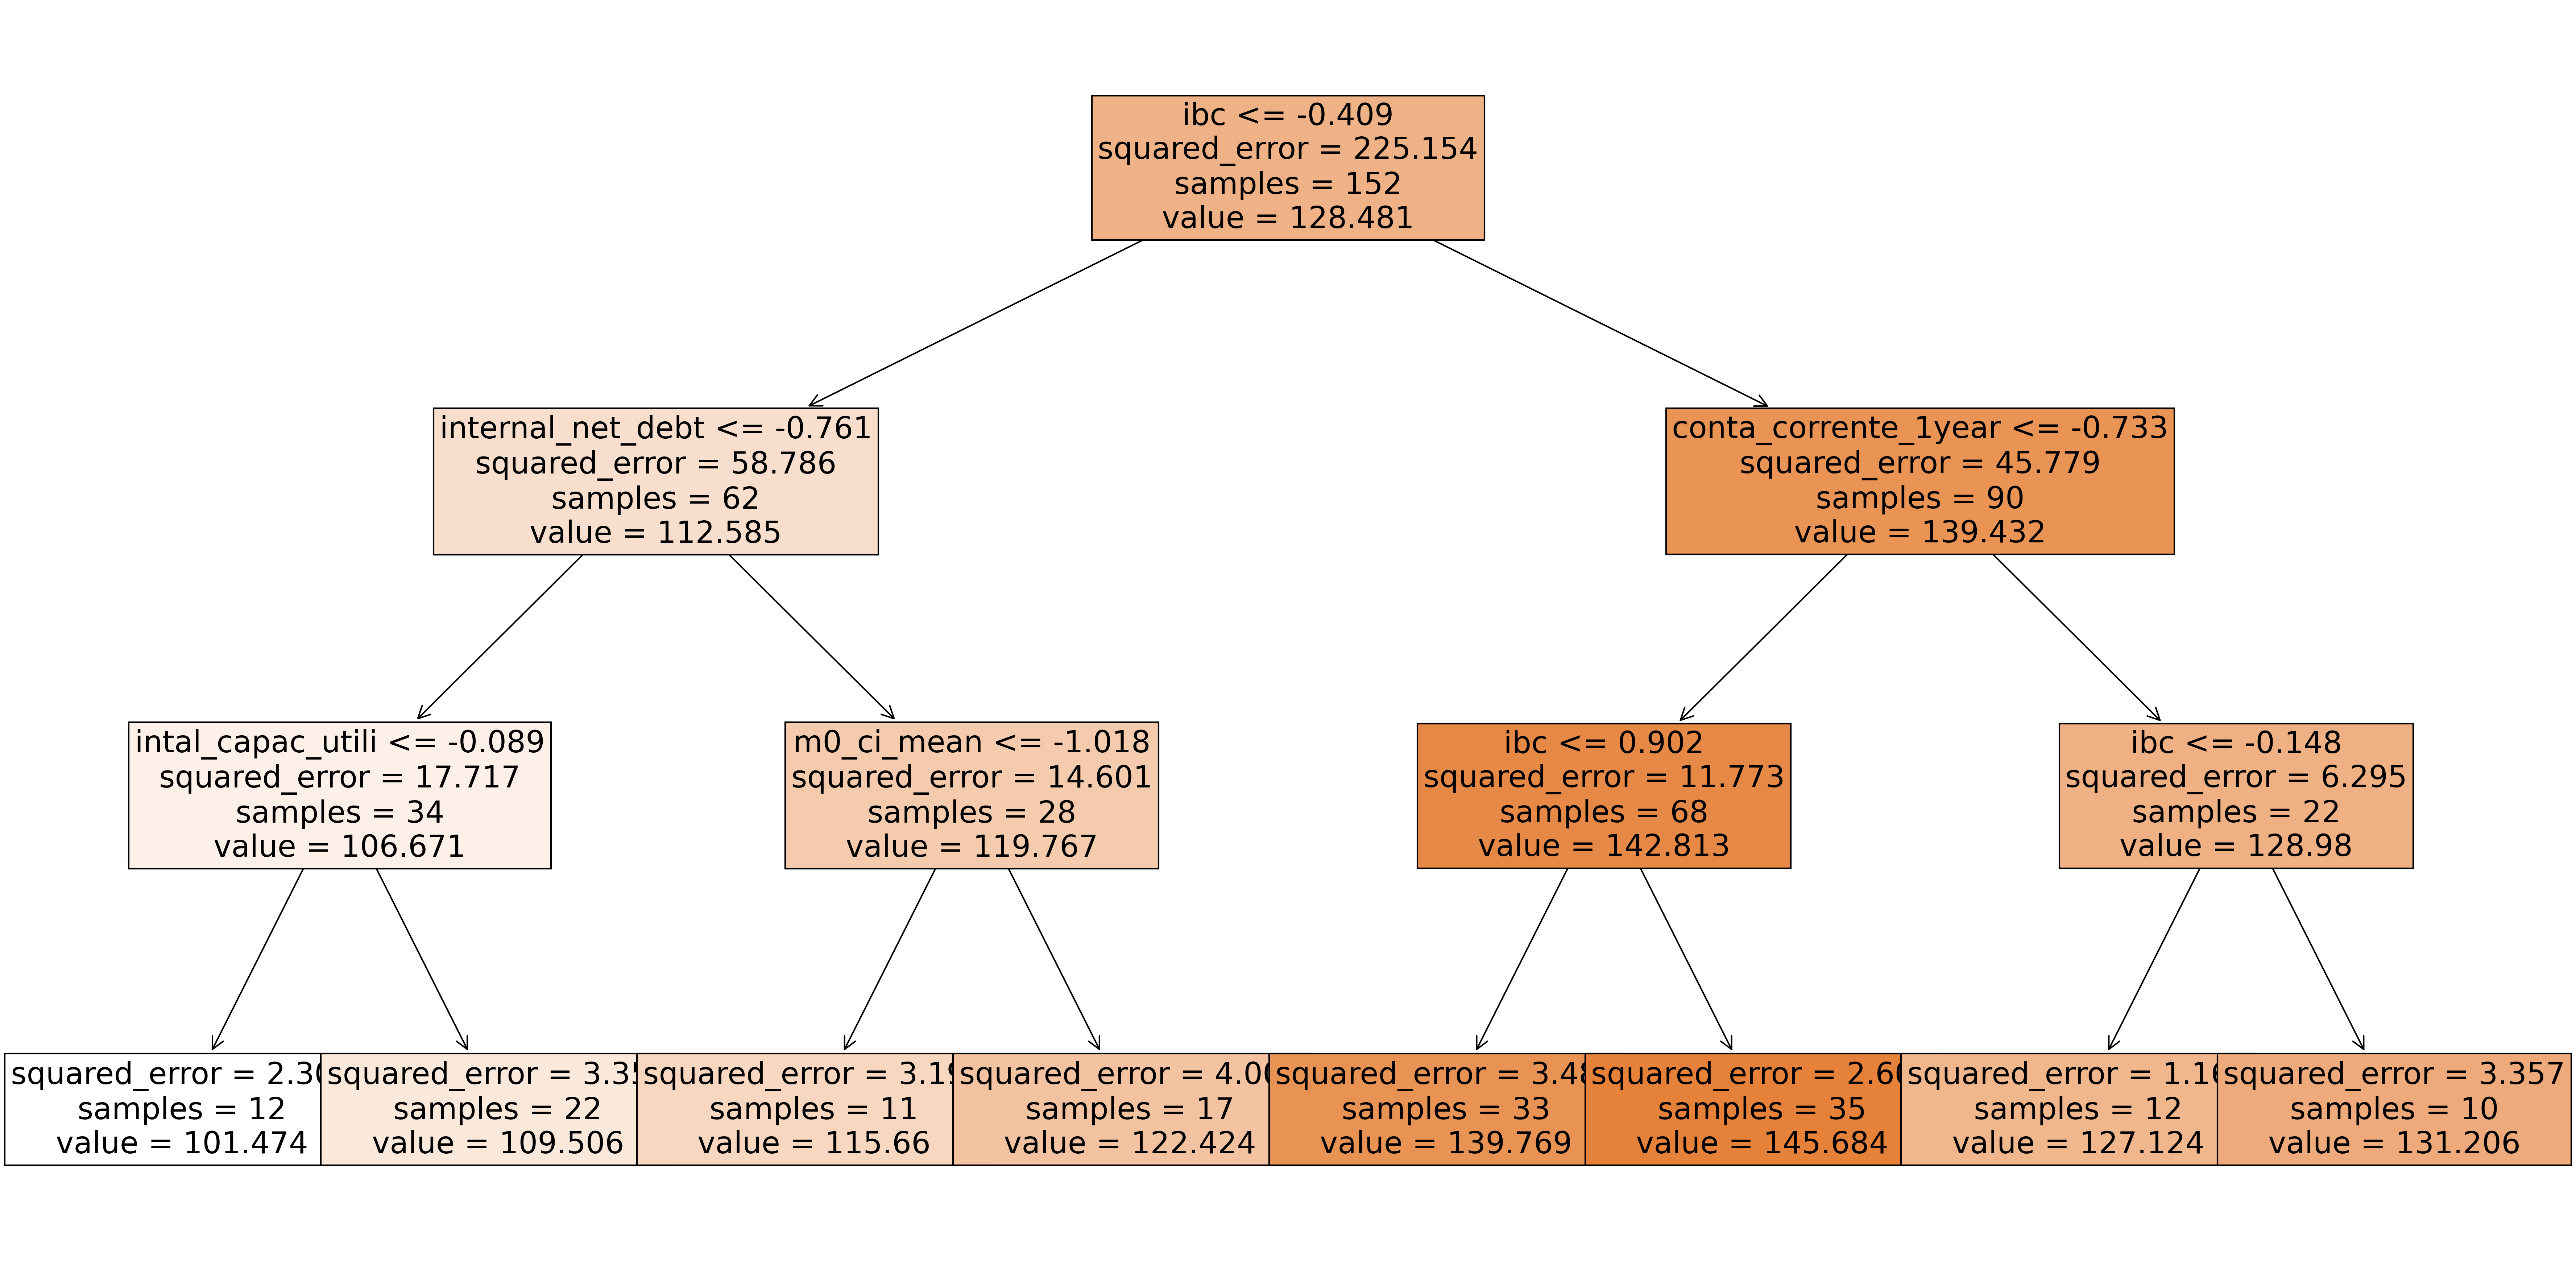

In [39]:
# Train a surrogate decision tree
surrogate = DecisionTreeRegressor(max_depth=3)
surrogate.fit(X_train, model.predict(X_train))

# Plot the surrogate decision tree
plt.figure(figsize=(30,15), dpi=300)  # Increase figure size and resolution
plot_tree(surrogate, feature_names=column_names_final, filled=True, fontsize=20)
plt.show()



In [42]:
# Decision tree model
Decision_Tree = DecisionTreeRegressor(max_depth=3)
Decision_Tree.fit(X_train, y_train)
Decision_Tree_predictions = Decision_Tree.predict(X_train)
Decision_Tree_mse = mean_squared_error(y_train, Decision_Tree_predictions)

# Predictions from the original model (boosted trees)
original_model_predictions = model.predict(X_train)

# Predictions from the surrogate model
surrogate_predictions = surrogate.predict(X_train)

# Calculate the mean squared error of the surrogate model
surrogate_mse = mean_squared_error(original_model_predictions, surrogate_predictions)

# Calculate the mean squared error of the original model
original_model_mse = mean_squared_error(y_train, original_model_predictions)

# Print the results
print(f"Mean Squared Error of the Decision Tree Model: {Decision_Tree_mse}")
print(f"Mean Squared Error of the Original Model: {original_model_mse}")
print(f"Mean Squared Error of the Surrogate Model: {surrogate_mse}")


Mean Squared Error of the Decision Tree Model: 3.192602024893964
Mean Squared Error of the Original Model: 0.01830578960542204
Mean Squared Error of the Surrogate Model: 3.0165652398651828


##### SHAP

In [43]:
# Create Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X_train)

# Get SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X_train)

In [44]:
#Calculate mean prediction 
mean_pred = np.mean(y_train_pred)

#Sum of interaction values for first row
sum_shap = np.sum(shap_values.values[0])

#Values below should be the same
print("Model prediction for first observation: {}".format(y_train_pred[0]))
print("Mean prediction + SHAP values for first observation: {}".format(mean_pred+sum_shap))

Model prediction for first observation: 101.75086212158203
Mean prediction + SHAP values for first observation: 101.73542022705078


##### Local interpretability

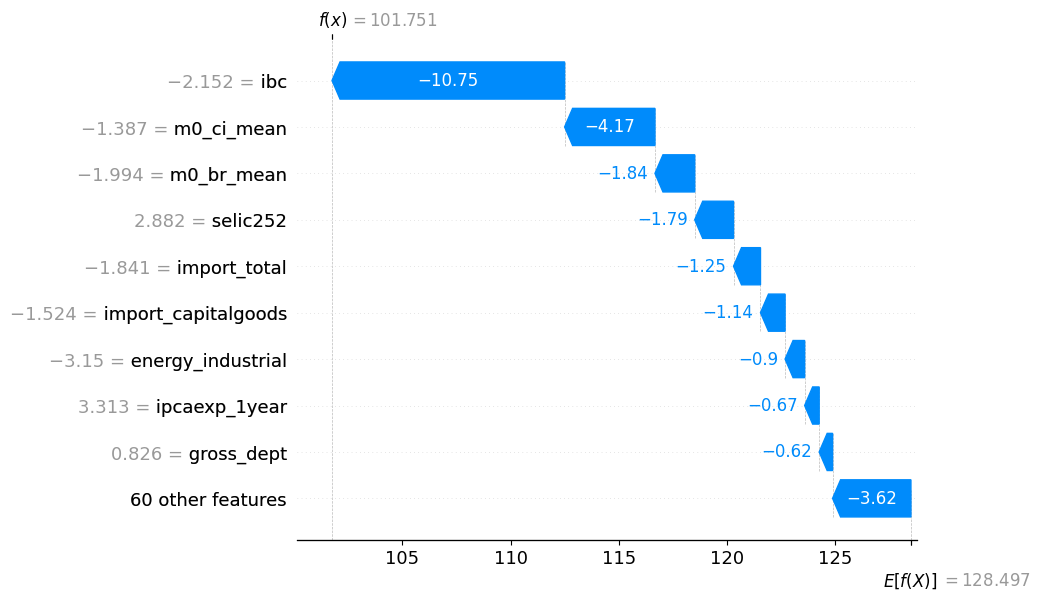

In [45]:
# First observation

shap.plots.waterfall(shap_values[0])


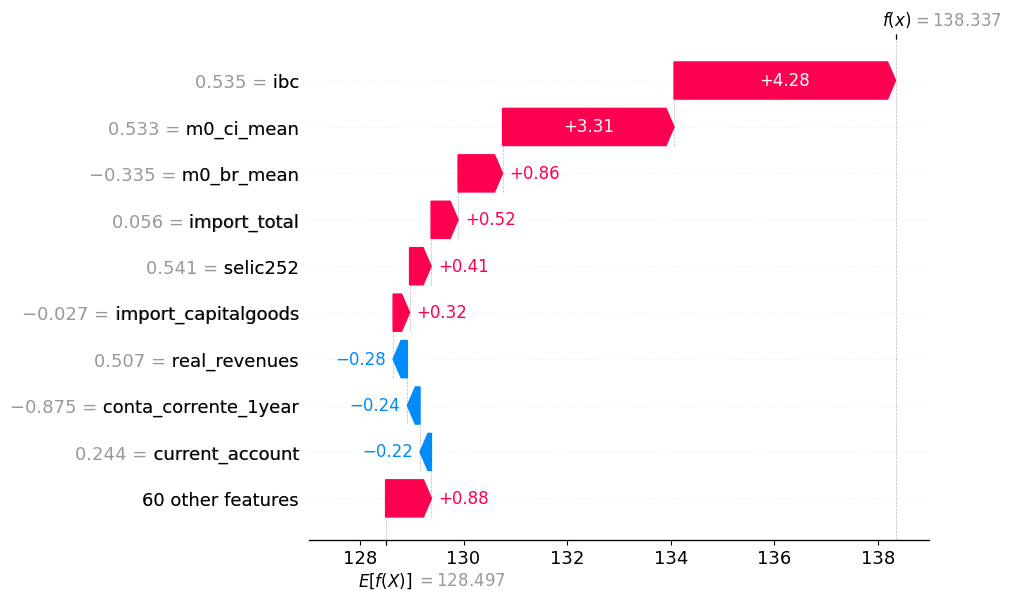

In [46]:
# Last observation

shap.plots.waterfall(shap_values[-1])

##### Global interpretability

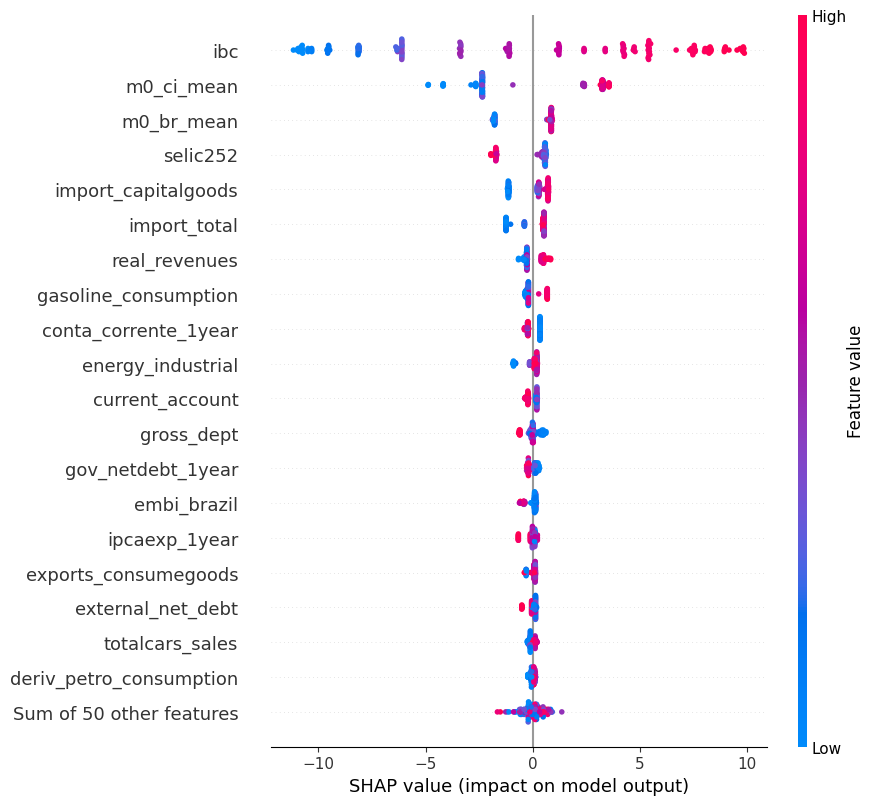

In [47]:
# Display beeswarm plot
shap.plots.beeswarm(shap_values,max_display = 20,show=False)
plt.gca().set_facecolor('white')

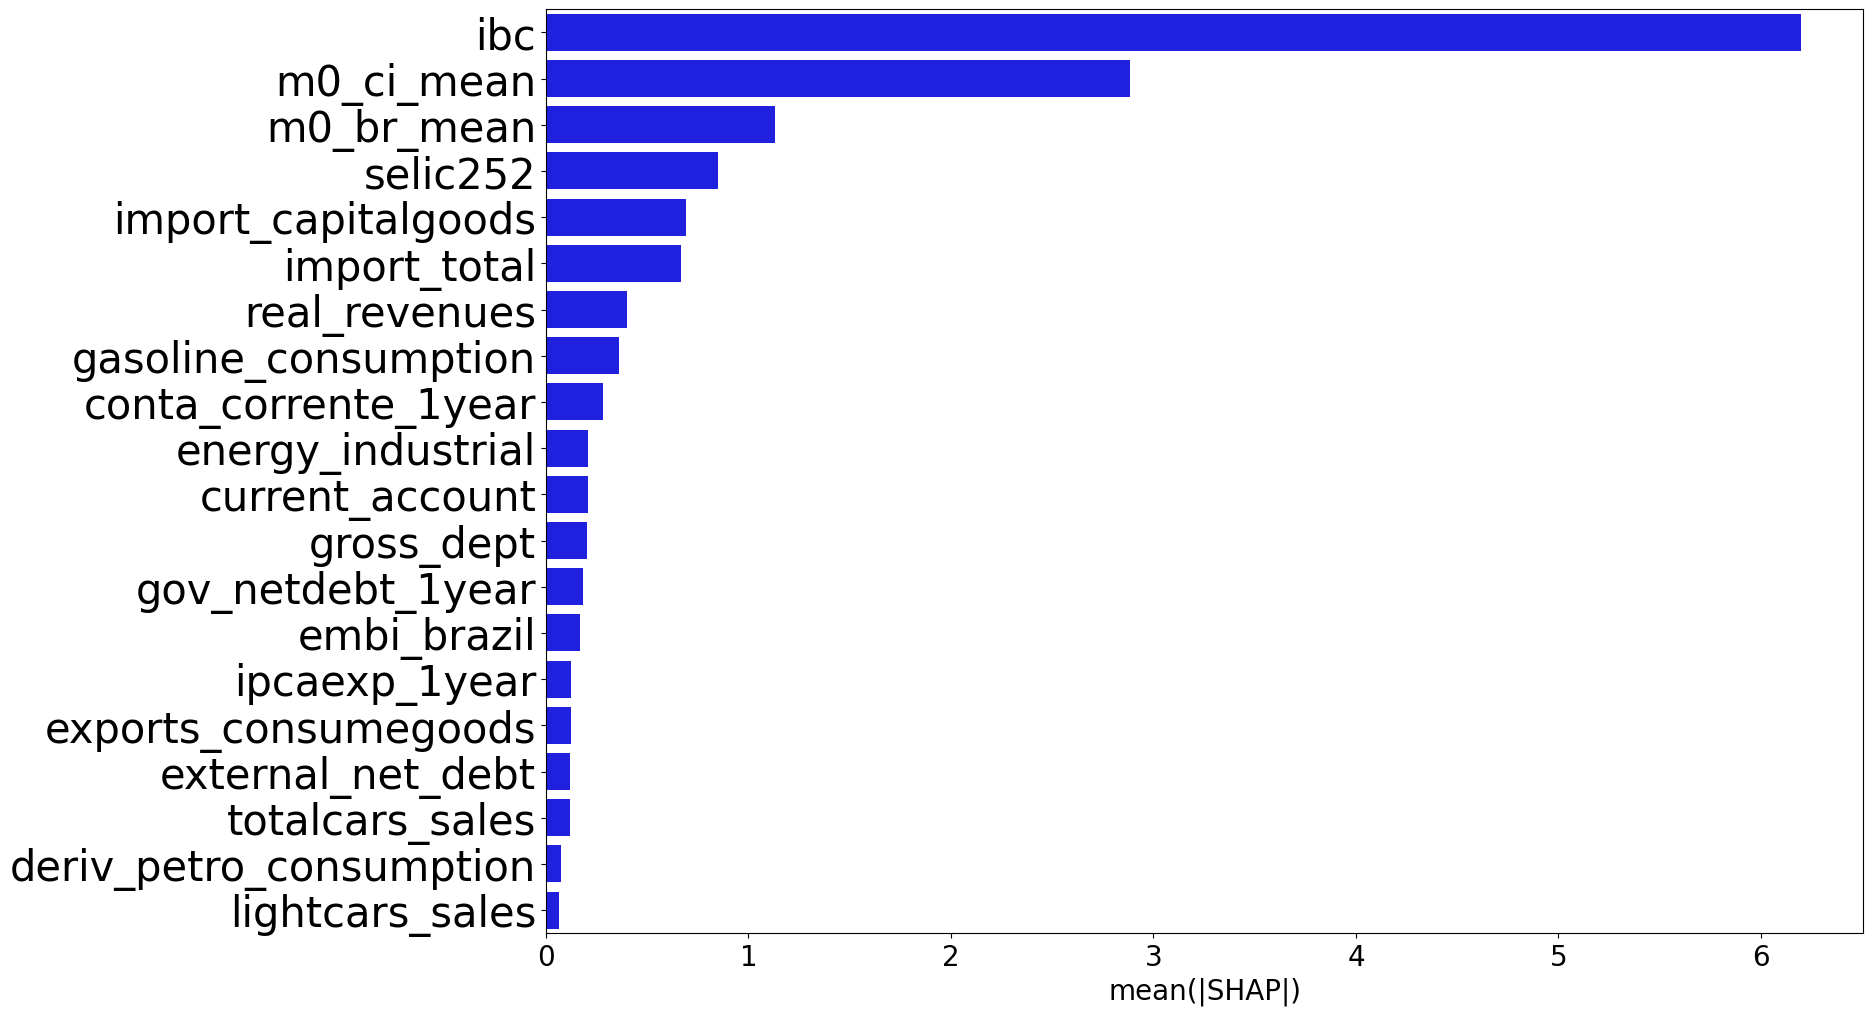

In [48]:
# Dataframe with average absolute SHAP values
abs_shap_values = np.abs(shap_values.values)
abs_shap_values = pd.DataFrame(abs_shap_values,columns=X_train.columns)
abs_shap_values_mean=abs_shap_values.mean(0)
abs_shap_values_mean = abs_shap_values_mean.sort_values(ascending=False)
my_order = abs_shap_values_mean.index

# Select top 20 features
top_20_features = abs_shap_values_mean[:20]

fig, ax = plt.subplots(figsize=(17, 12))
plt.yticks(fontsize=30)
plt.xticks(fontsize=20)
ax.grid(False)
plt.gca().set_facecolor('white')
sns.barplot(x=top_20_features.values, y=top_20_features.index, orient="h",color="blue")
plt.xlabel('mean(|SHAP|)', fontsize=20)
plt.show()

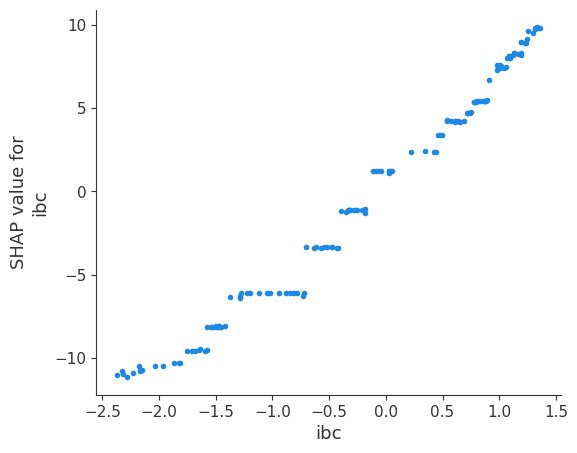

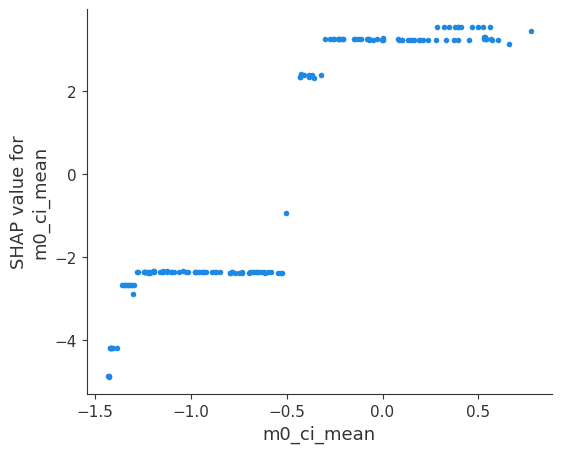

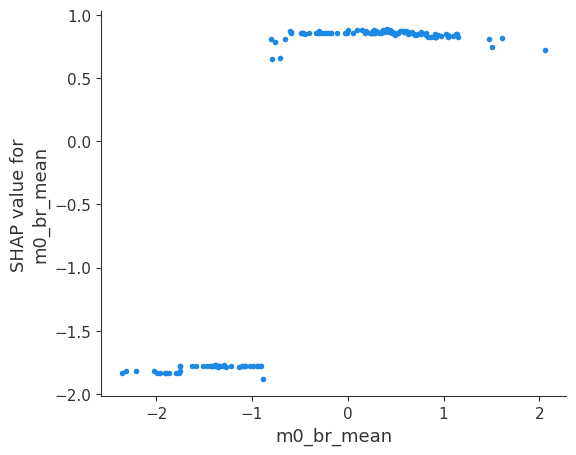

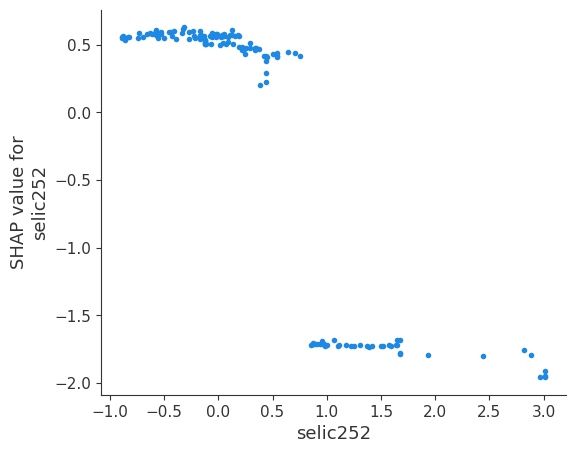

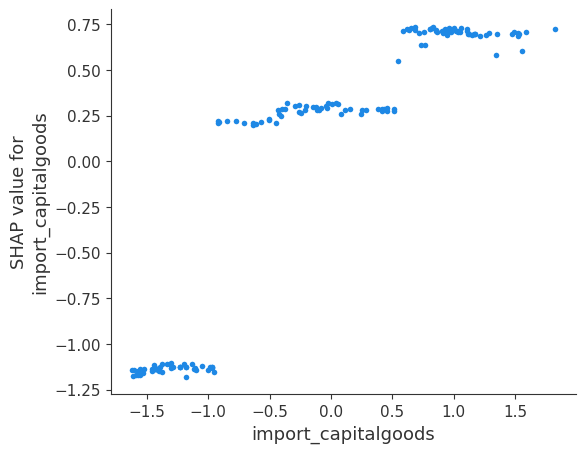

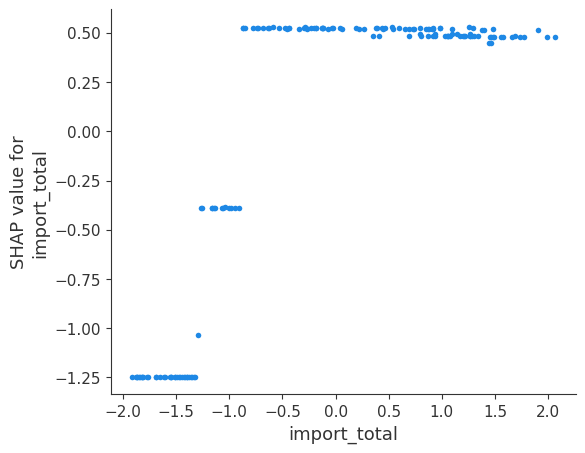

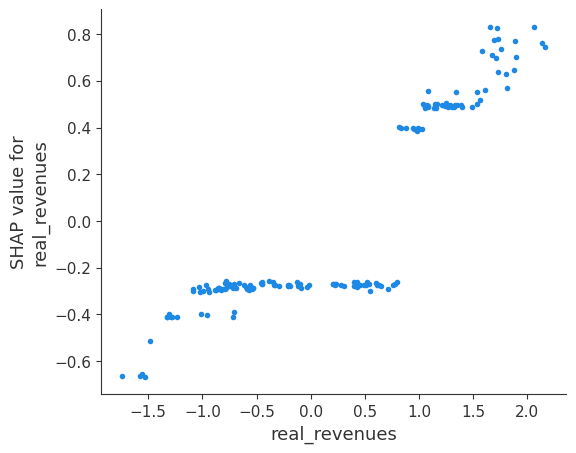

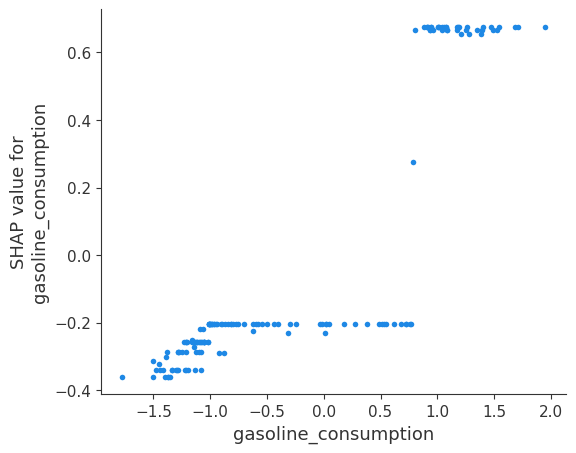

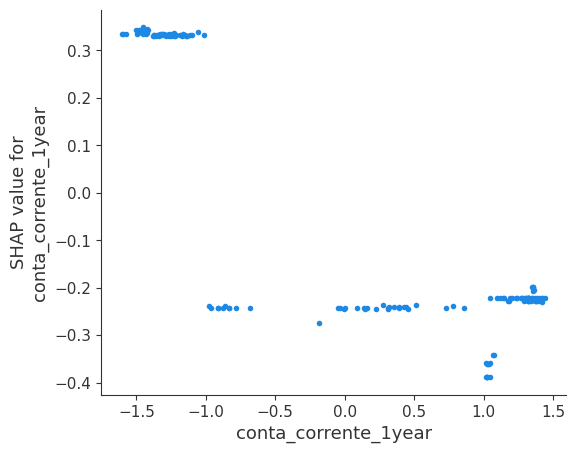

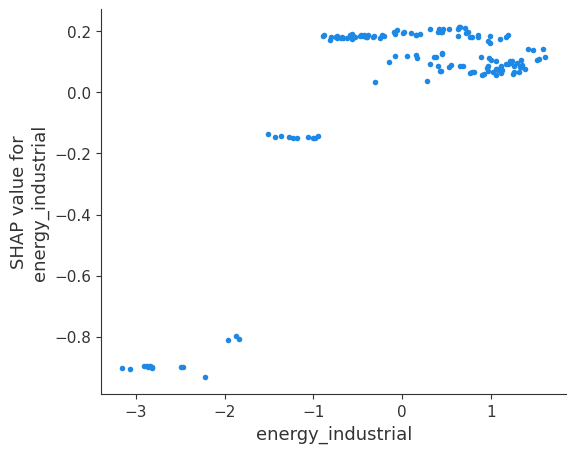

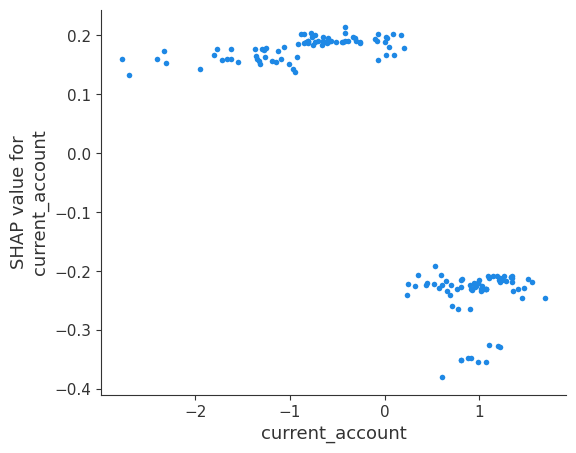

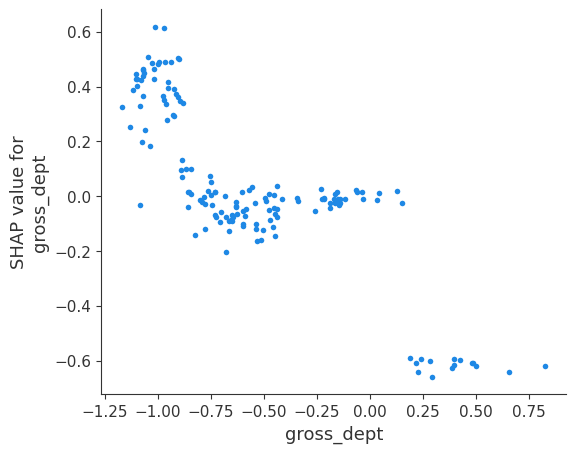

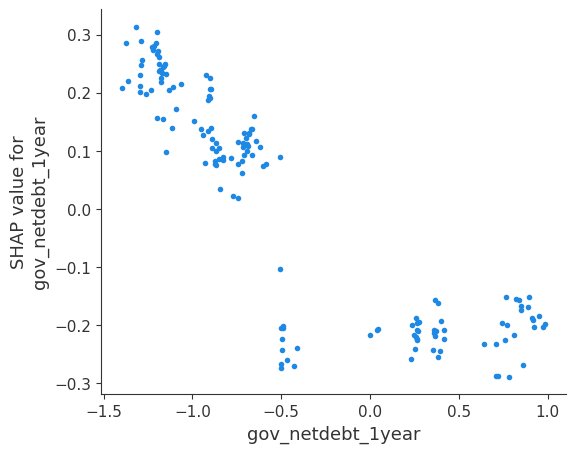

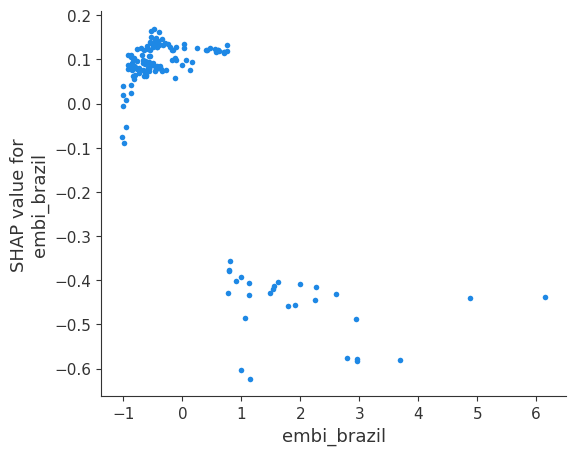

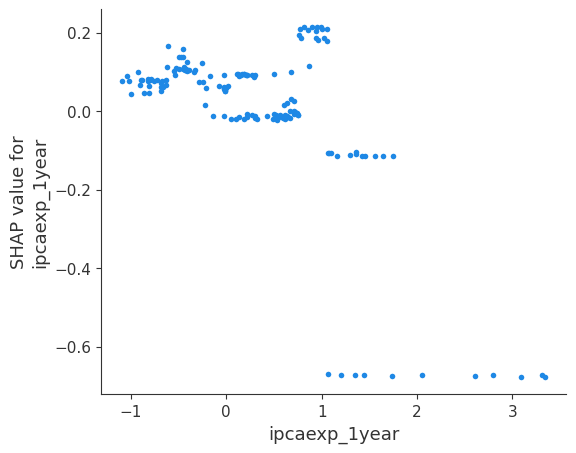

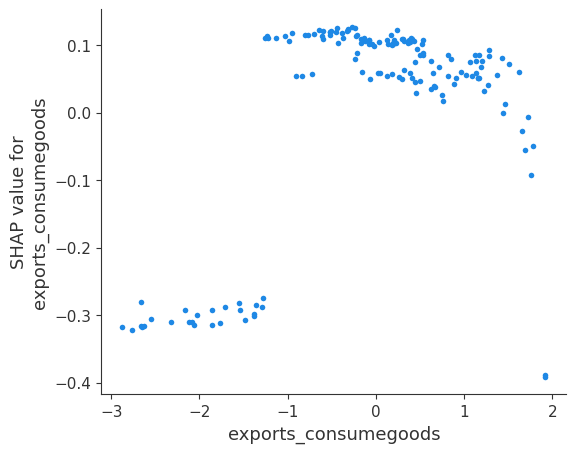

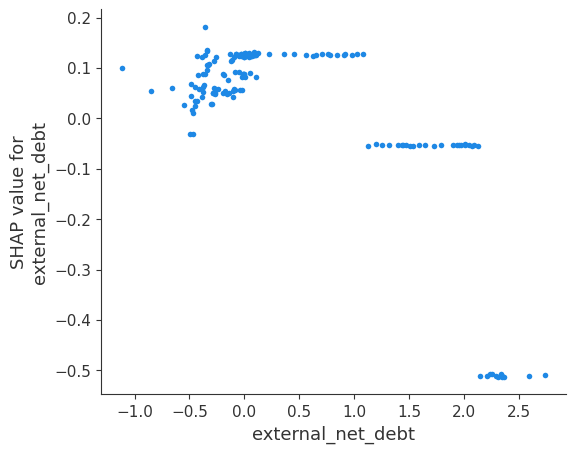

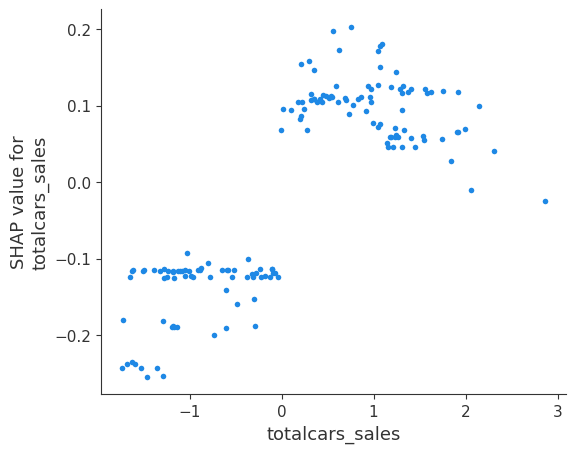

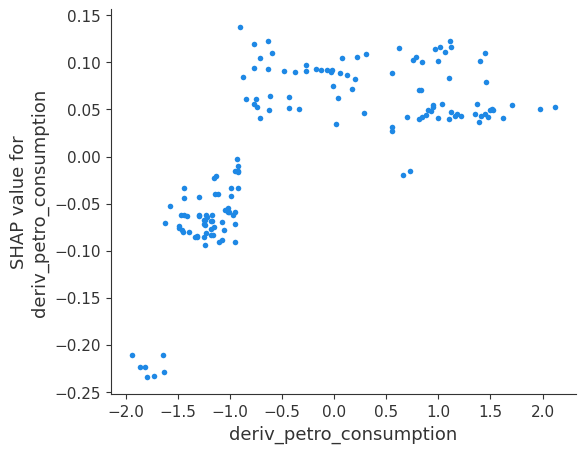

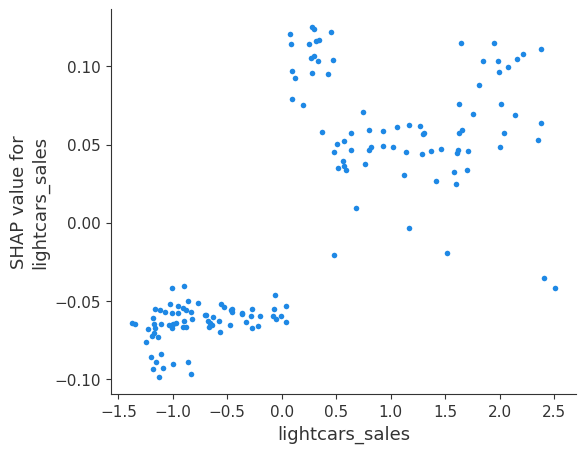

In [49]:
for feature in top_20_features.index:
    shap.dependence_plot(feature, shap_values.values, X_train, interaction_index=None, show=False)
    plt.show()


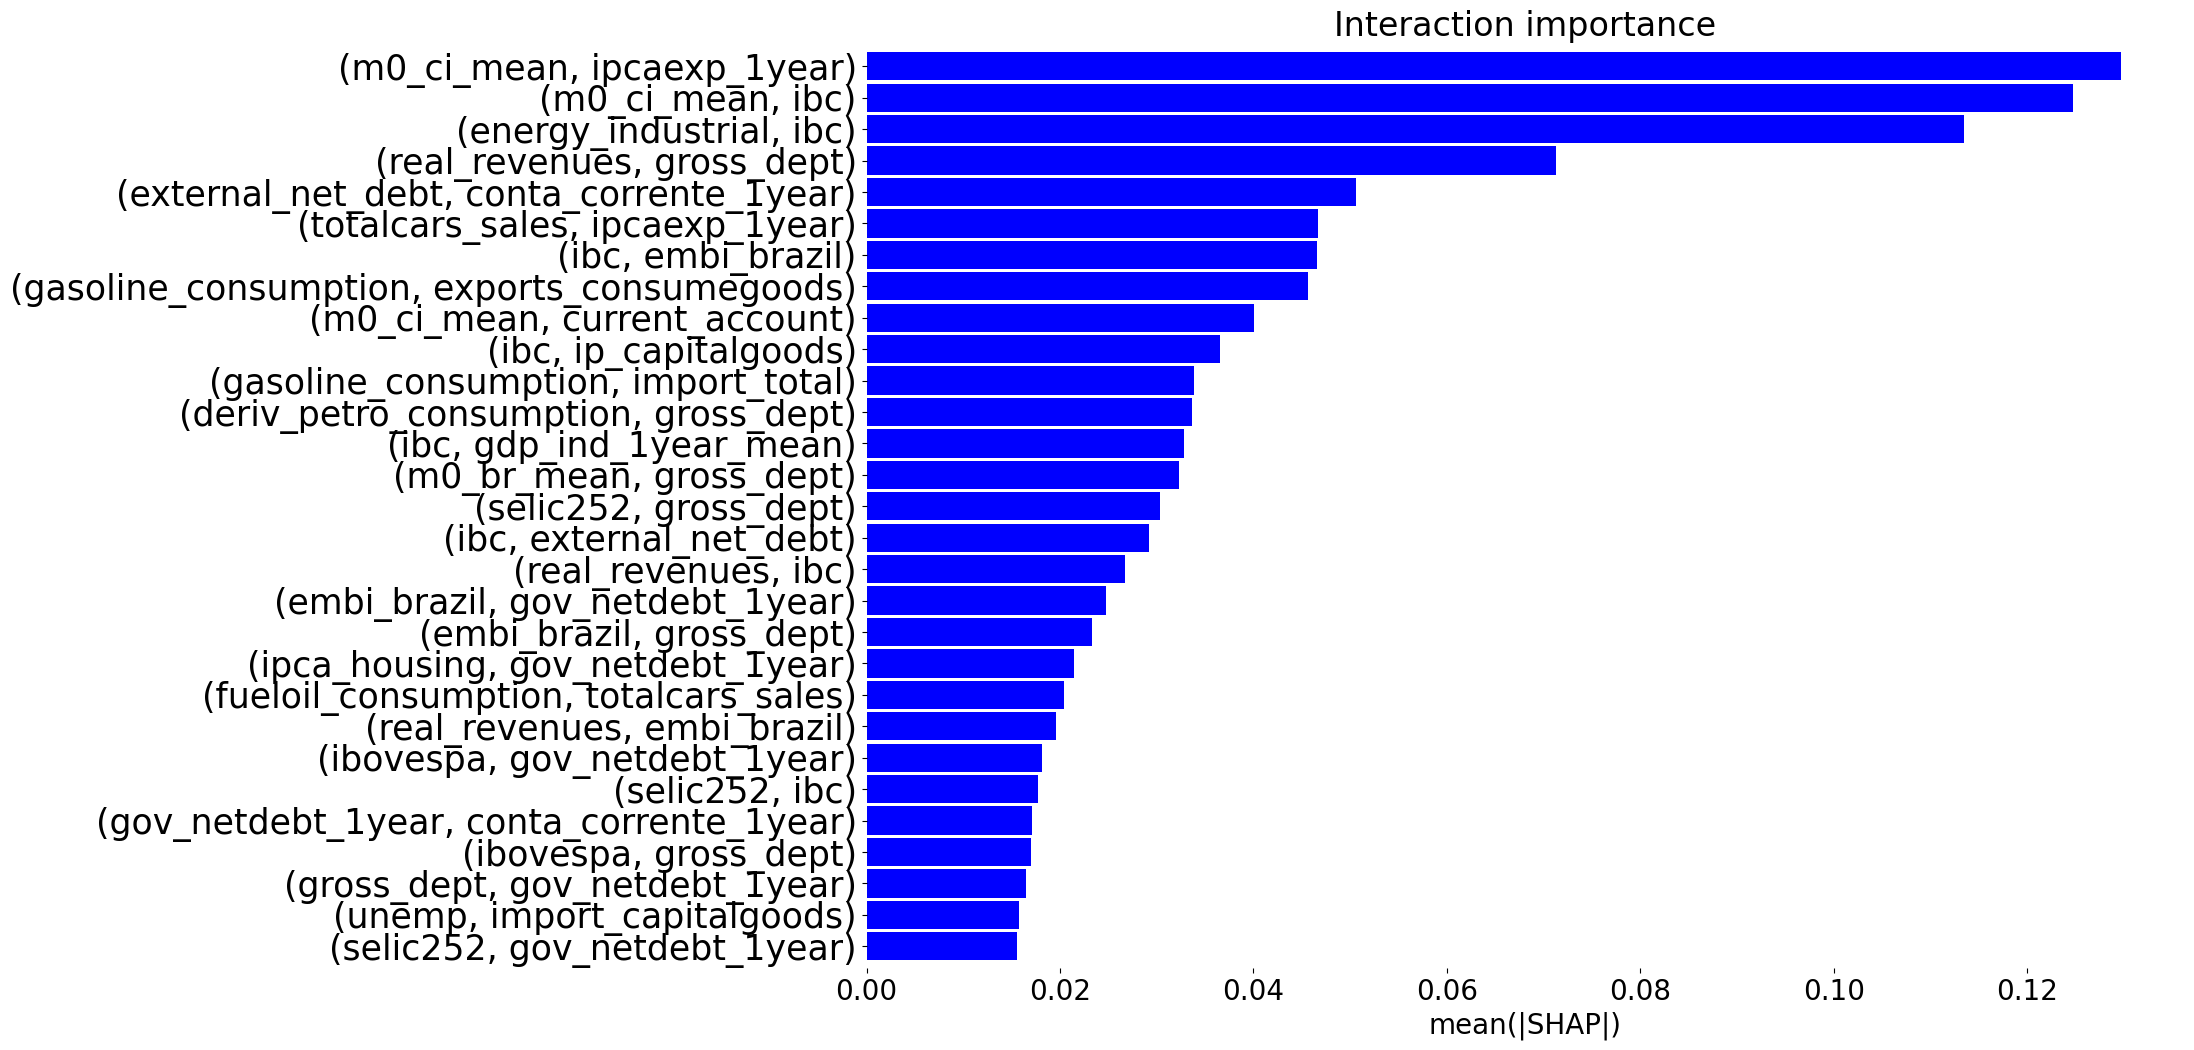

In [50]:
# create barplot of interaction values

# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df_interactions = pd.DataFrame(mean_shap,index=X_train.columns,columns=X_train.columns)

# times off diagonal by 2
df_interactions.where(df_interactions.values == np.diagonal(df_interactions),df_interactions.values*2,inplace=True)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of SHAP interaction matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_interactions(df):
    au_corr = df.unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

interaction_bar_plot = get_interactions(df_interactions)

interaction_bar_plot = interaction_bar_plot[0:29].sort_values(ascending=True)

fig, ax = plt.subplots(figsize =(17,12))
plt.yticks(fontsize=25)
plt.xticks(fontsize=20)
norm = TwoSlopeNorm(vmin=-1, vcenter =0, vmax=1)
colors = [plt.cm.RdYlGn(norm(c)) for c in interaction_bar_plot.values]
interaction_bar_plot.plot.barh(color="blue",width = 0.9)
ax.set_facecolor('white')
sns.despine(bottom=True,left=True)
plt.xlabel('mean(|SHAP|)', fontsize=20)  # Add x-axis label
plt.title('Interaction importance', fontsize=24)  # Add title
plt.show()


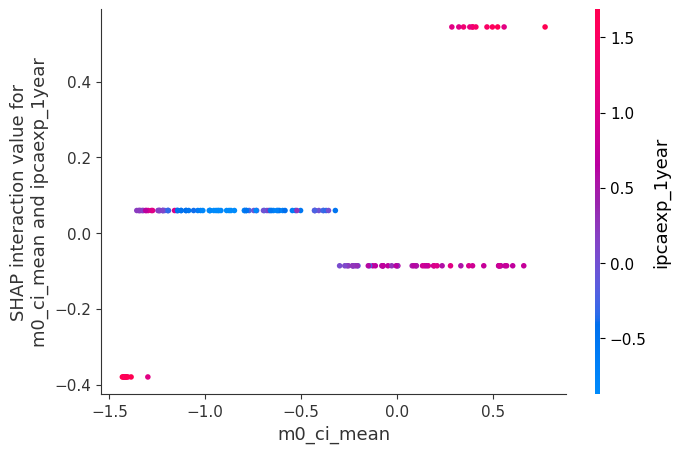

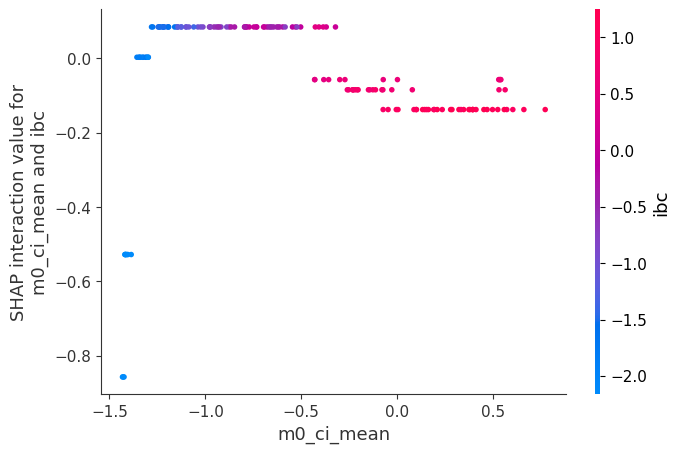

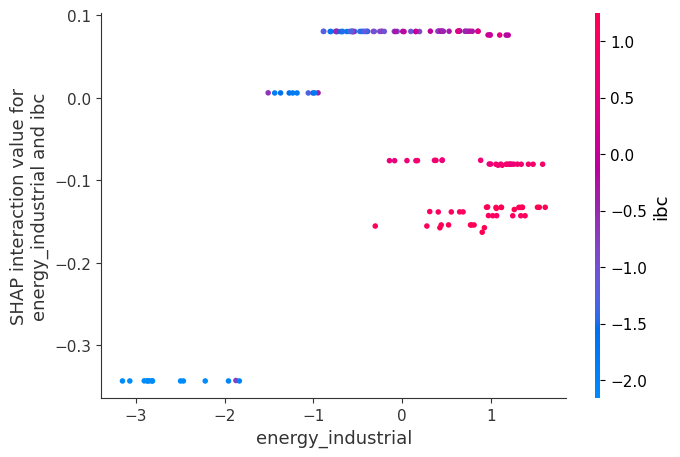

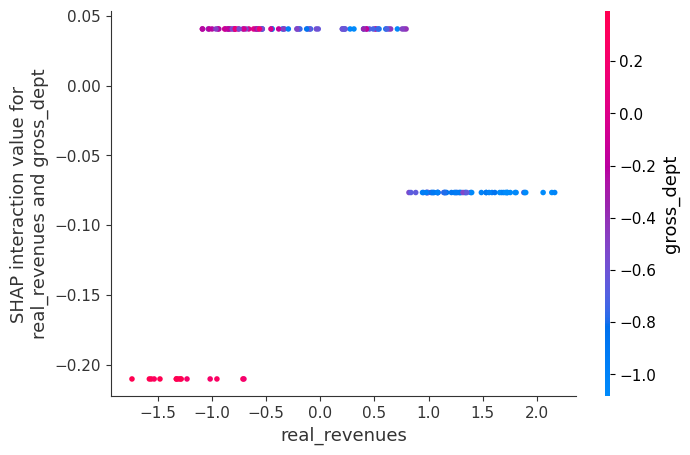

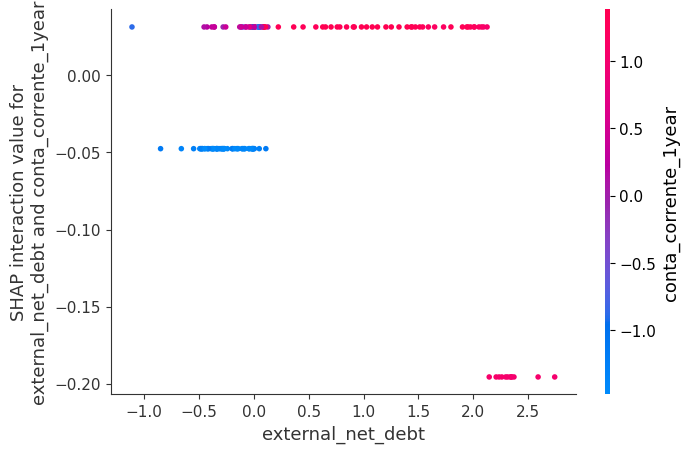

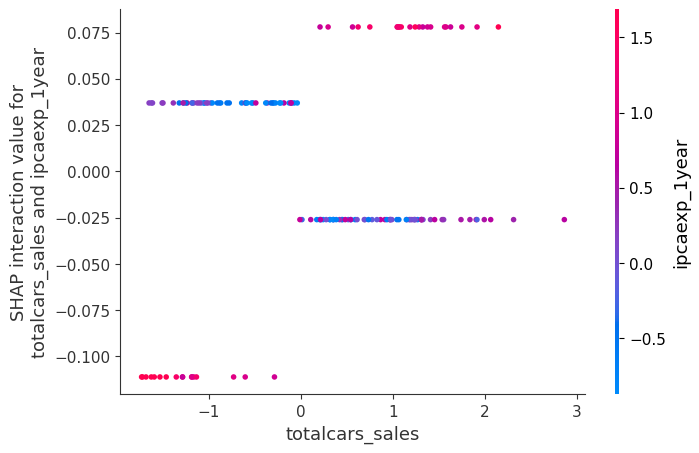

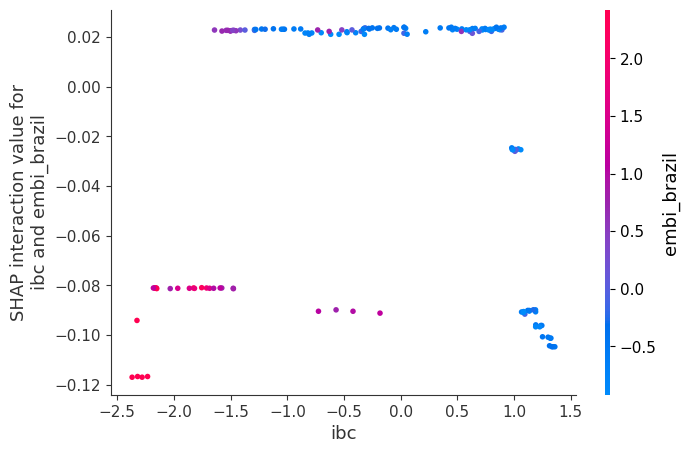

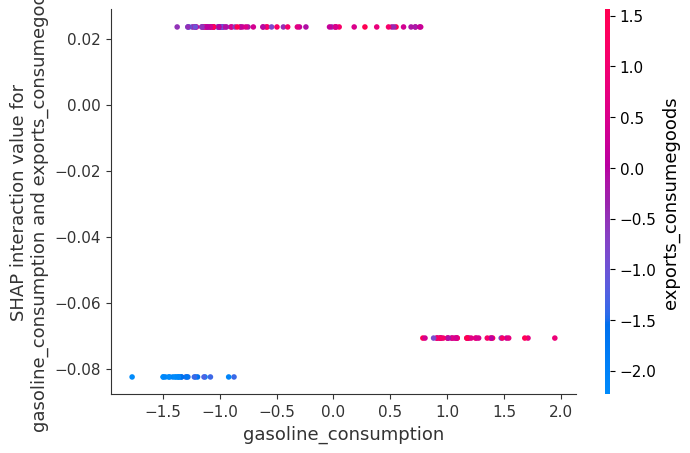

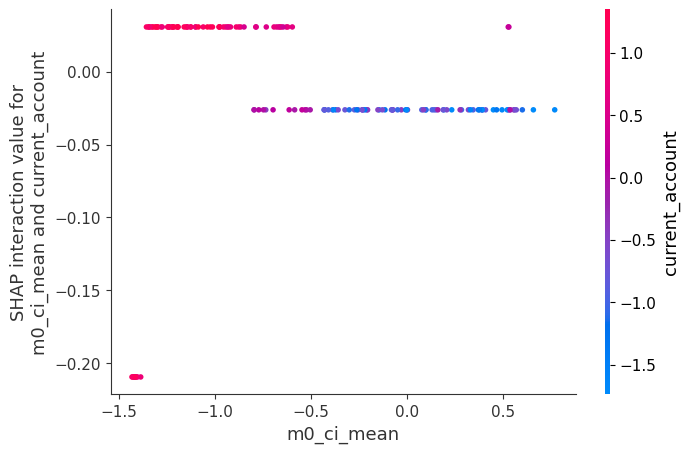

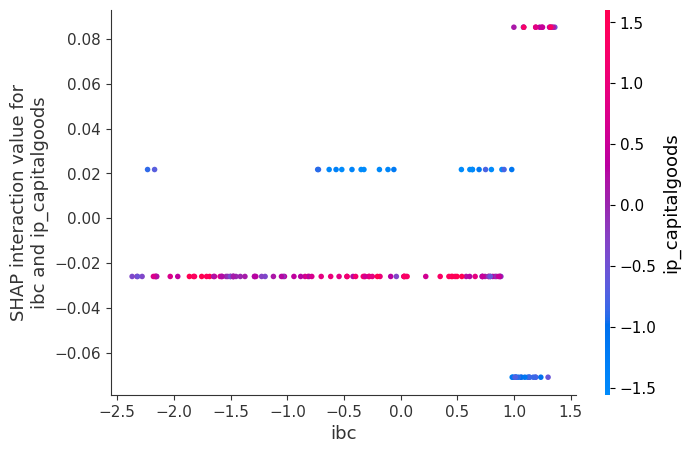

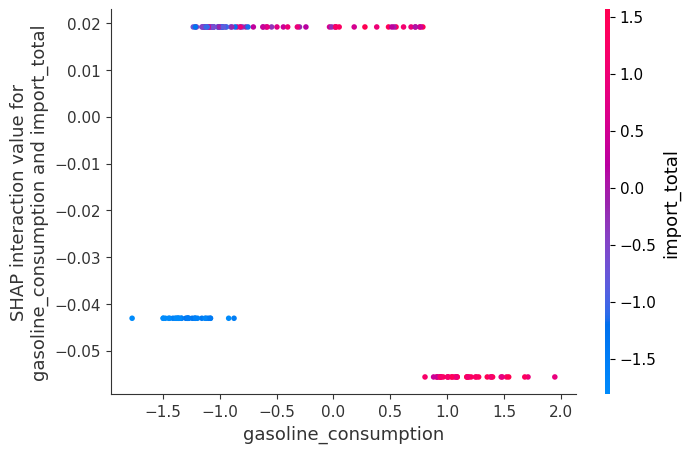

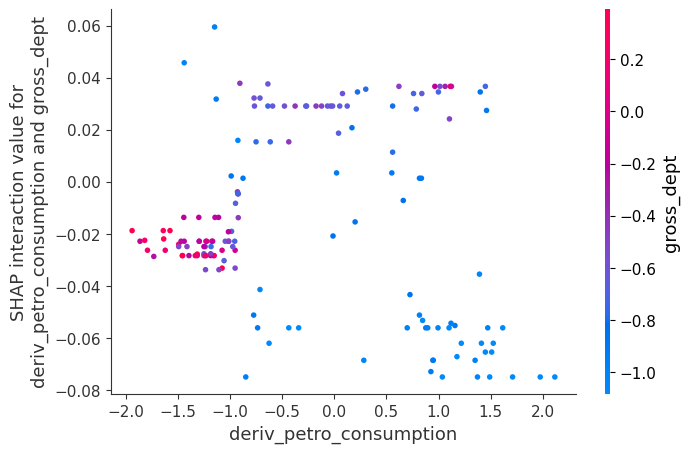

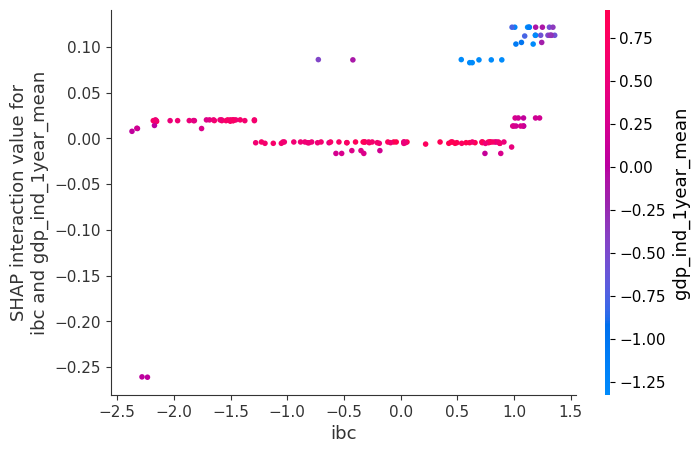

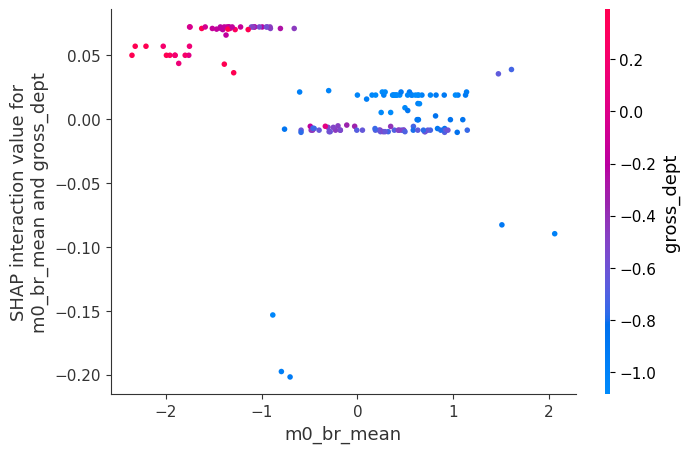

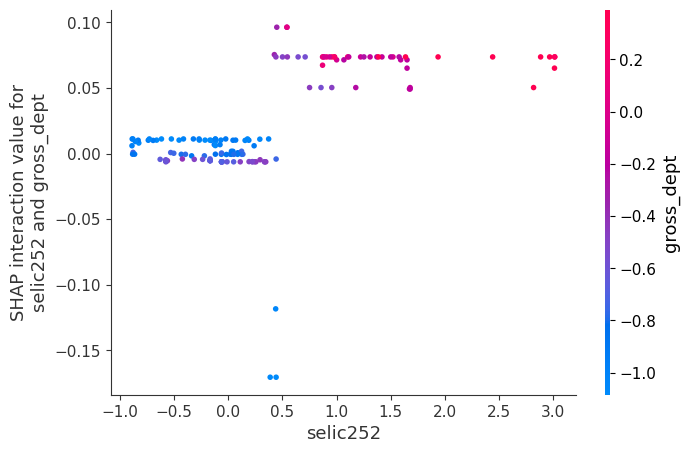

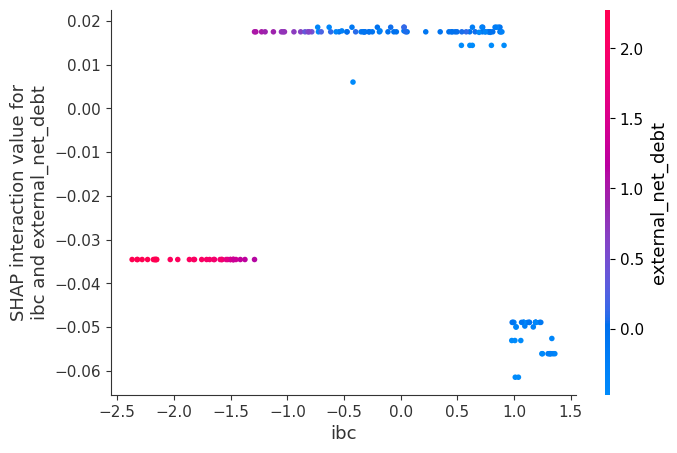

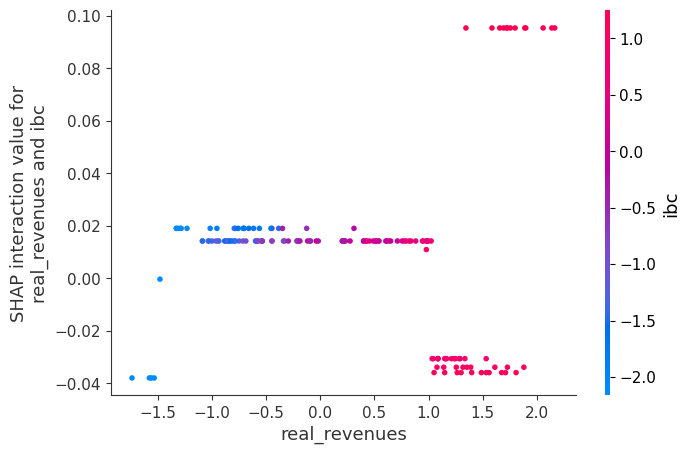

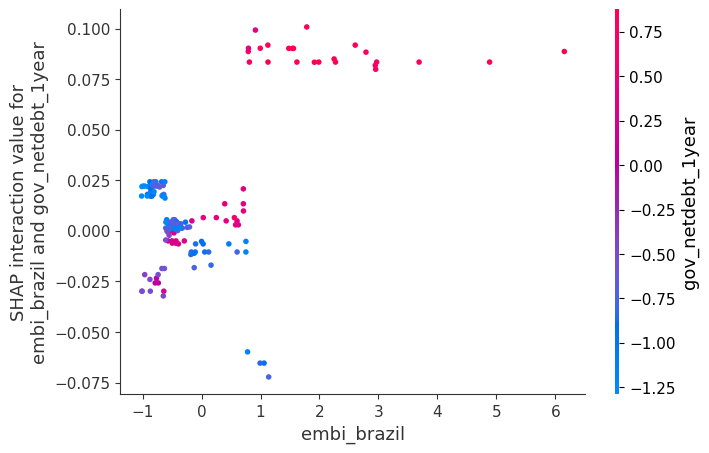

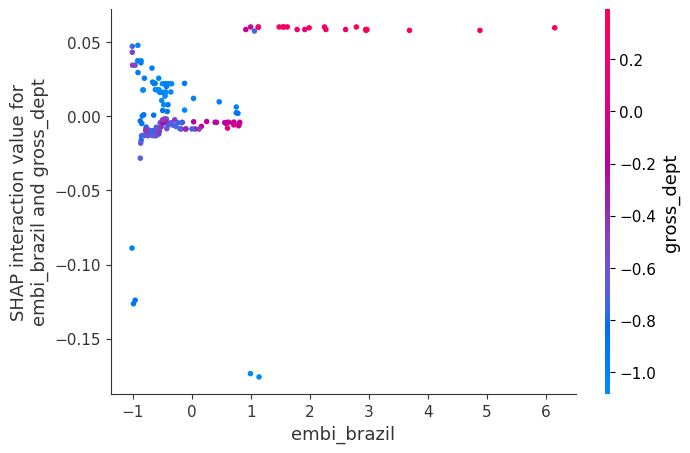

In [51]:
interaction_bar_plot = interaction_bar_plot.sort_values(ascending=False)

for i in range(19):
    shap.dependence_plot(
        (interaction_bar_plot.index[i][0], interaction_bar_plot.index[i][1]),
        np.asarray(shap_interaction), X_train,
        display_features=X_train,show=False)